# Neural Networks

Problema propusa este construirea unui model pentru citirea si adaugarea numerelor. 
Numerele sunt de la 1 pana la 3 cifre, iar cel mai mare numar este 255.
Imaginile cu numere au dimensiunea 28x84 px.

## Task 1: Image Classification

Construirea unui model folosind CNN pentru a recunoaste numarul dintr-o imagine.

In [2]:
from google.colab import files
files.upload()

Saving data_generator.py to data_generator.py


{'data_generator.py': b'import random\nimport cv2\nimport numpy as np\n\nfrom imgaug import augmenters as iaa\nfrom tensorflow.keras import datasets\n\n(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()\n\ndef sometimes(aug): return iaa.Sometimes(0.5, aug)\n\nseq = iaa.Sequential([\n    iaa.Affine(\n        scale={"x": (0.8, 1), "y": (0.8, 1)},\n        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},\n        rotate=(-15, 15),\n        shear=(-5, 5),\n        cval=(0, 0),\n        mode=\'constant\'\n    )\n])\n\n\ndef crop_number(number):\n    """\n        Crops a MNIST digit to its containing bounding box with some random noise.\n    """\n    vsum = np.sum(number, axis=0)\n    vsum[vsum > 0] = 1\n    vdif = np.diff(vsum)\n    vdif[vdif > 0] = 1\n    xs = np.argwhere(vdif > 0).ravel()\n\n    random_cut1 = np.random.randint(-1, 3)\n    random_cut2 = np.random.randint(-1, 3)\n\n    try:\n        cropped_number = number[0:28, xs[0] - random_cut1:xs[1] + random_cut2]

### Generarea setului de date

Am ales sa folosesc 5.000 perechi de numere pentru train si 500 perechi de test. 

In [3]:
import data_generator
import numpy as np

training_set = data_generator.training_generator(5000)
test_set = data_generator.test_generator(500)
X, y, y_sum = next(training_set)
X_test, y_test, y_sum_test = next(test_set)

X1 = [el[0] for el in X]
X2 = [el[1] for el in X]
X = np.array(X1 + X2)

y1 = [el[0] for el in y]
y2 = [el[1] for el in y]
y = np.array(y1 + y2)

X1 = [el[0] for el in X_test]
X2 = [el[1] for el in X_test]
X_test = np.array(X1 + X2)

y1 = [el[0] for el in y_test]
y2 = [el[1] for el in y_test]
y_test = np.array(y1 + y2)

11493376/11490434 [==============================] - 0s 0us/step


### Normalizarea setului de date

Datele au fost normalizate prin impartirea la 255.0, iar etichetele transformate in one hot encoder.

In [4]:
import tensorflow as tf
from tensorflow import keras

number_of_classes = 256
data_height = 28
data_width = 84

X = X / 255.0
X_test = X_test / 255.0
y = keras.utils.to_categorical(y, number_of_classes)
y_test = keras.utils.to_categorical(y_test, number_of_classes)
X = X.reshape(X.shape[0], data_height, data_width, 1)
X_test = X_test.reshape(X_test.shape[0], data_height, data_width, 1)

print(X.shape)
print(y.shape)

(10000, 28, 84, 1)
(10000, 256)


### Vizualizarea datelor

Au fost plotate 10 imagini pentru a vedea cum arata datele.

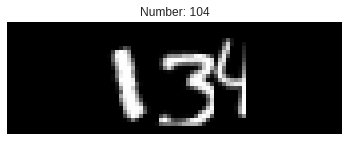

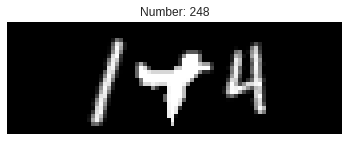

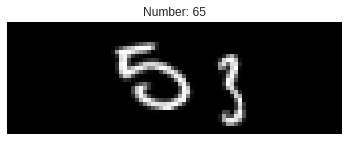

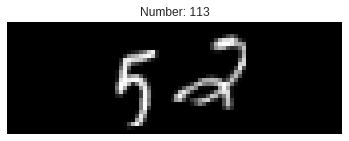

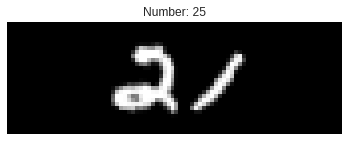

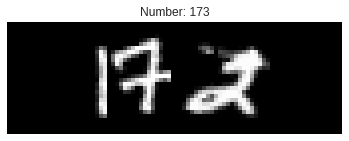

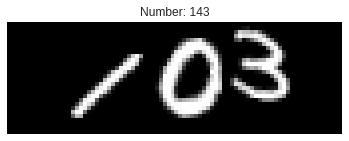

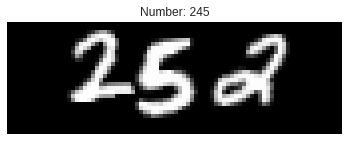

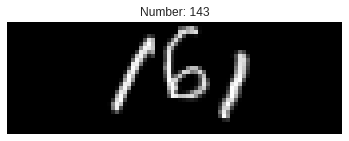

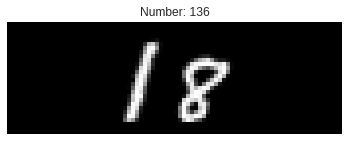

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

training_set_plot = data_generator.training_generator(10)
test_set_plot = data_generator.test_generator(5)
X_plot, y_plot, y_sum_plot = next(training_set_plot)
X_test_plot, y_test_plot, y_sum_test_plot = next(test_set_plot)

X1_plot = [el[0] for el in X_plot]
X2_plot = [el[1] for el in X_plot]
X_plot = np.array(X1_plot + X2_plot)

y1_plot = [el[0] for el in y_plot]
y2_plot = [el[1] for el in y_plot]
y_plot = np.array(y1 + y2)

X1_plot = [el[0] for el in X_test_plot]
X2_plot = [el[1] for el in X_test_plot]
X_test_plot = np.array(X1_plot + X2_plot)

y1_plot = [el[0] for el in y_test_plot]
y2_plot = [el[1] for el in y_test_plot]
y_test_plot = np.array(y1_plot + y2_plot)

for i in range(10):
    fig = plt.figure(i)
    plt.tight_layout()
    plt.imshow(X_plot[i], cmap='gray', interpolation='none')
    plt.title("Number: {}".format(y_plot[i]))
    plt.xticks([])
    plt.yticks([])

## Modelul si structura acestuia

Pentru model a fost variat hyperparametrul optimizer, unde learning rate a fost variat.
Am construit un model care contine 10 layere: de la 1 la 8 avem Convolutional Layers, care aplica niste filtre pe imagini, apoi fiind trimise catre layerul urmator. Am utilizat pentru Activation function "relu" si oentru kernel_initializer "he_normal". De la layerul 8 am adaugat functia Flatten(), care creaza un vector din matricea ce rezulta pentru a facilita modelul. De asemenea, am mai folosit functia Dense(), care reduce dimensionalitatea vectorului obtinut prin Flatten(). Pe ultimul layer am modificat Activation function in "softmax". Am folosit "categorical_crossentropy" pentru pierderi (loss) si "categorical_accuracy" pentru acuratetea modelului.

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, RepeatVector
from keras.optimizers import Adam, SGD

def model1(optimizer, lr):
    number_of_classes = 256
    data_height = 28
    data_width = 84
    input_shape = X.shape[1:]

    if optimizer == "sgd":
        my_optimizer = SGD(lr=lr)
    elif optimizer == "adam":
        my_optimizer = Adam(lr=lr)
    else:
        my_optimizer = "adam"

    model = Sequential()

    # 1
    model.add(Conv2D(16, (5, 5), padding="SAME", input_shape=input_shape, kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))

    # 2
    model.add(Conv2D(32, (3, 3), padding="SAME", kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3
    model.add(Conv2D(64, (5, 5), kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))

    # 4
    model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 5
    model.add(Conv2D(256, (3, 3), kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))

    # 6
    model.add(Conv2D(128, (2, 2), kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    # 7
    model.add(Conv2D(64, (1, 1), kernel_initializer="he_normal"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))

    # 8
    model.add(Conv2D(32, (1, 1), kernel_initializer="he_normal"))
    model.add(Activation('relu'))
    model.add(Flatten())
    
    # 9
    model.add(Dense(512))
    model.add(Activation('relu'))
    
    # 10
    model.add(Dense(256))
    model.add(Activation('softmax'))

    model.compile(loss="categorical_crossentropy", optimizer=my_optimizer, metrics=['categorical_accuracy'])
    return model

models = []
parameters = [{"optimizer": "sgd", "lr": 0.001}, 
              {"optimizer": "sgd", "lr": 0.01},
              {"optimizer": "sgd", "lr": 0.1},
              {"optimizer": "adam", "lr": 0.001},
              {"optimizer": "adam", "lr": 0.01},
              {"optimizer": "adam", "lr": 0.1}]
for params in parameters:
    models.append({"model": model1(**params),
                   "params": params,
                   "history": None,
                   "Accuracy": None
                  })    

Using TensorFlow backend.


### Antrenarea modelelor

Modelele au fost antrenate pentru 10 epoci.

In [7]:
class LossAccHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracies = []
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('categorical_accuracy'))

for index, model_info in enumerate(models):
    epochs = 10
    batch_size = 32
    validation_split = 0.1
    history = LossAccHistory()
    model_info["model"].fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[history])
    model_info["history"] = history
    models[index] = model_info
    model_info["model"].save("model_"+ str(index) + ".h5")

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 13s 1ms/step - loss: 5.6710 - categorical_accuracy: 0.0030 - val_loss: 5.6116 - val_categorical_accuracy: 0.0060
Epoch 2/10
9000/9000 [==============================] - 8s 927us/step - loss: 5.5846 - categorical_accuracy: 0.0049 - val_loss: 5.5797 - val_categorical_accuracy: 0.0090
Epoch 3/10
9000/9000 [==============================] - 8s 929us/step - loss: 5.5276 - categorical_accuracy: 0.0071 - val_loss: 5.5570 - val_categorical_accuracy: 0.0070
Epoch 4/10
9000/9000 [==============================] - 8s 932us/step - loss: 5.4827 - categorical_accuracy: 0.0102 - val_loss: 5.5426 - val_categorical_accuracy: 0.0060
Epoch 5/10
9000/9000 [==============================] - 9s 950us/step - loss: 5.4442 - categorical_accuracy: 0.0137 - val_loss: 5.5307 - val_categorical_accuracy: 0.0100
Epoch 6/10
9000/9000 [==============================] - 9s 949us/step - loss: 5.4040 - categorical_accu

### Evaluarea modelelor pe datele de test

In [8]:
batch_size=32
for index, model_info in enumerate(models):
    model = model_info["model"]
    accuracy_and_loss = model.evaluate(X_test, y_test, batch_size=batch_size)
    model_info["accuracy"] = accuracy_and_loss[1]
    models[index] = model_info
    print("Params: ", model_info["params"])
    print("[Loss, Accuracy]: ", accuracy_and_loss)

1000/1000 [==============================] - 0s 346us/step
Params:  {'optimizer': 'sgd', 'lr': 0.001}
[Loss, Accuracy]:  [5.455744842529297, 0.015]
1000/1000 [==============================] - 0s 308us/step
Params:  {'optimizer': 'sgd', 'lr': 0.01}
[Loss, Accuracy]:  [1.350089319229126, 0.635]
1000/1000 [==============================] - 0s 285us/step
Params:  {'optimizer': 'sgd', 'lr': 0.1}
[Loss, Accuracy]:  [0.5919470648765564, 0.865]
1000/1000 [==============================] - 0s 287us/step
Params:  {'optimizer': 'adam', 'lr': 0.001}
[Loss, Accuracy]:  [0.5217292526215315, 0.891]
1000/1000 [==============================] - 0s 276us/step
Params:  {'optimizer': 'adam', 'lr': 0.01}
[Loss, Accuracy]:  [0.6364483013153076, 0.863]
1000/1000 [==============================] - 0s 273us/step
Params:  {'optimizer': 'adam', 'lr': 0.1}
[Loss, Accuracy]:  [16.069741088867186, 0.003]


### Plotarea pierderilor din fiecare model

{'optimizer': 'sgd', 'lr': 0.001}
{'optimizer': 'sgd', 'lr': 0.01}
{'optimizer': 'sgd', 'lr': 0.1}
{'optimizer': 'adam', 'lr': 0.001}
{'optimizer': 'adam', 'lr': 0.01}
{'optimizer': 'adam', 'lr': 0.1}


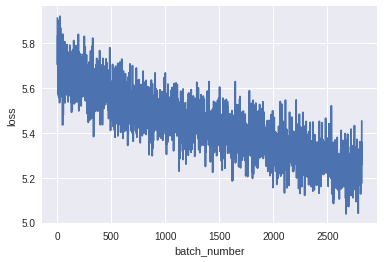

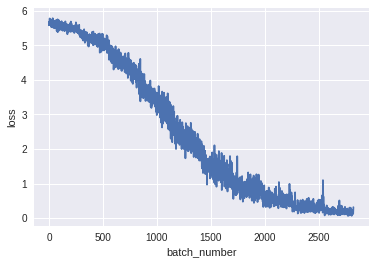

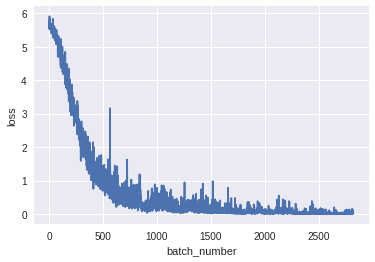

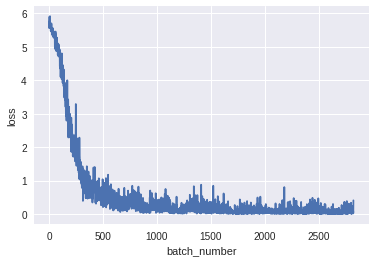

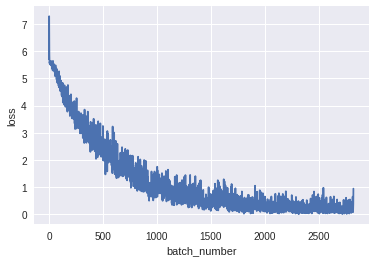

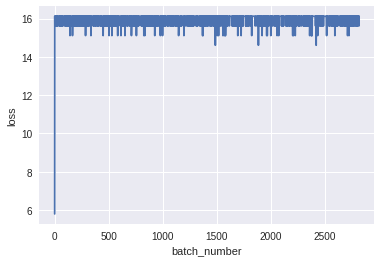

In [9]:
for i, model_info in enumerate(models):
    print(model_info["params"])
    plt.figure(i)
    plt.xlabel("batch_number")
    plt.ylabel("loss")
    history_loss = model_info["history"]
    plt.plot(range(len(history_loss.losses)), history_loss.losses)

### Plotarea acuratetii din fiecare model

{'optimizer': 'sgd', 'lr': 0.001}
{'optimizer': 'sgd', 'lr': 0.01}
{'optimizer': 'sgd', 'lr': 0.1}
{'optimizer': 'adam', 'lr': 0.001}
{'optimizer': 'adam', 'lr': 0.01}
{'optimizer': 'adam', 'lr': 0.1}


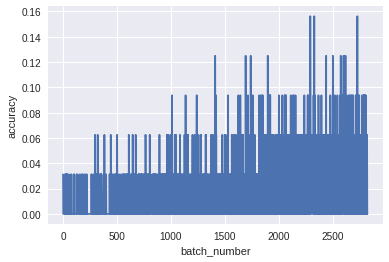

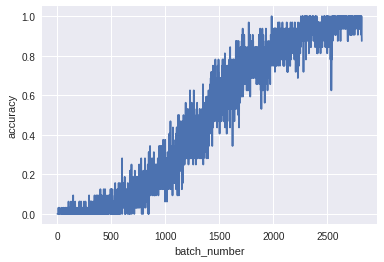

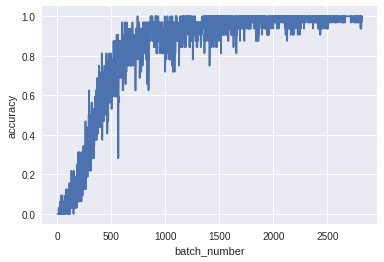

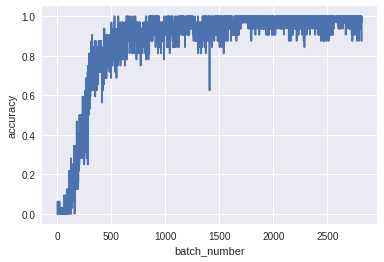

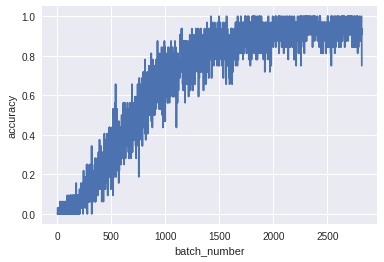

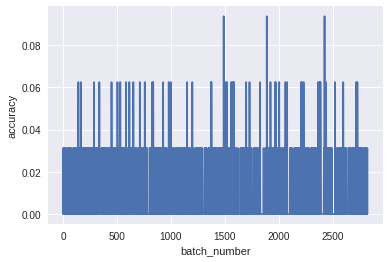

In [10]:
for i, model_info in enumerate(models):
    print(model_info["params"])
    plt.figure(i)
    plt.xlabel("batch_number")
    plt.ylabel("accuracy")
    history_acc = model_info["history"]
    plt.plot(range(len(history_acc.accuracies)), history_acc.accuracies)

## Task 2: Addition

Folosirea Recurrent Neural Network pentru calculul sumei a doua numere.

### Generarea setului de date

In [0]:
# [10, 122] => "10+122 "
def stringify(X, y): 
    max_length = len("255+255")
    X_new = []
    for sample in X:
        sample_after = '+'.join([str(n) for n in sample])
        sample_after = sample_after + ''.join([' ' for _ in range(max_length - len(sample_after))])
        X_new.append(sample_after)
    y_new = []
    max_length = len(str(255+255))
    for sample in y:
        sample_after = str(sample)
        sample_after = sample_after + ''.join([' ' for _ in range(max_length - len(sample_after))])
        y_new.append(sample_after)
    return X_new, y_new   

# ["255+10 "] => [2, 5, 5, 10, 1, 0, 11]
def intenc(X, y, alphabet):
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    X_enc = []
    for sample in X:
        intencoded = [char_to_int[char] for char in sample]
        X_enc.append(intencoded)
    y_enc = []
    for sample in y:
        intencoded = [char_to_int[char] for char in sample]
        y_enc.append(intencoded)
    return X_enc, y_enc

def ohenc(X, y, max_int):
    X_enc = []
    for seq in X:
        sample = []
        for index in seq:
            ohenced = [0 for _ in range(max_int)]
            ohenced[index] = 1
            sample.append(ohenced)
        X_enc.append(sample)
    y_enc = []
    for seq in y:
        sample = []
        for index in seq:
            ohenced = [0 for _ in range(max_int)]
            ohenced[index] = 1
            sample.append(ohenced)
        y_enc.append(sample)
    return X_enc, y_enc


alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', ' ']

training_set = data_generator.training_generator(10000)
test_set = data_generator.test_generator(1000)
X, y, y_sum = next(training_set)
X_test, y_test, y_sum_test = next(test_set)

y = [[el[0], el[1]] for el in y]
y_sum = [list(el)[0] for el in y_sum]

y_test = [[el[0], el[1]] for el in y_test]
y_sum_test = [list(el)[0] for el in y_sum_test]

X, y, X_test, y_test = y, y_sum, y_test, y_sum_test

X, y = stringify(X, y)
X_test, y_test = stringify(X_test, y_test)

X, y = intenc(X, y, alphabet)
X_test, y_test = intenc(X_test, y_test, alphabet)
X, y = ohenc(X, y, len(alphabet))
X_test, y_test = ohenc(X_test, y_test, len(alphabet))

X, y, X_test, y_test = np.array(X), np.array(y), np.array(X_test), np.array(y_test)

## Modelul si structura acestuia

Pentru model a fost variat hyperparametrul optimizer, unde learning rate a fost variat. Am construit un model care contine 3 layere: 1 si 2 sunt LSTM (Long short-term memory), iar ultimul are un apel al lui Dense() care va reduce dimensionalitatea si Activation function in "softmax". Am folosit "categorical_crossentropy" pentru pierderi (loss) si "categorical_accuracy" pentru acuratetea modelului.


In [0]:
from keras.layers.recurrent import LSTM

def model2(optimizer, lr):
    out_sequence_length = len(str(255+255))
    in_seq_length = len("255+255")
    out_shape = len(alphabet)
    
    if optimizer == "sgd":
        my_optimizer = SGD(lr=lr)
    elif optimizer == "adam":
        my_optimizer = Adam(lr=lr)
    else:
        my_optimizer = "adam"

    model = Sequential()

    # 1
    model.add(LSTM(150, input_shape=(in_seq_length, out_shape)))
    model.add(RepeatVector(out_sequence_length))

    # 2
    model.add(LSTM(100, return_sequences=True))

    # 3
    model.add(Dense(12))
    model.add(Activation("softmax"))
    model.compile(loss='categorical_crossentropy', optimizer=my_optimizer, metrics=['accuracy'])
    return model

models2 = []
parameters = [{"optimizer": "sgd", "lr": 0.001}, 
              {"optimizer": "sgd", "lr": 0.01},
              {"optimizer": "sgd", "lr": 0.1},
              {"optimizer": "adam", "lr": 0.001},
              {"optimizer": "adam", "lr": 0.01},
              {"optimizer": "adam", "lr": 0.1}]
for params in parameters:
    models2.append({"model": model2(**params),
                   "params": params,
                   "history": None,
                   "Accuracy": None
                  })

### Antrenarea modelelor

In [15]:
class LossAccHistory2(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracies = []
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))

for index, model_info in enumerate(models2):
    epochs = 50
    batch_size = 32
    validation_split = 0.1
    history = LossAccHistory2()
    model_info["model"].fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[history])
    model_info["history"] = history
    models2[index] = model_info
    model_info["model"].save("model2_"+ str(index) + ".h5")

Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 9s 988us/step - loss: 2.3147 - acc: 0.1883 - val_loss: 2.3189 - val_acc: 0.1873
Epoch 2/50
9000/9000 [==============================] - 9s 1ms/step - loss: 2.3138 - acc: 0.1883 - val_loss: 2.3180 - val_acc: 0.1873
Epoch 3/50
9000/9000 [==============================] - 9s 1ms/step - loss: 2.3130 - acc: 0.1883 - val_loss: 2.3172 - val_acc: 0.1873
Epoch 4/50
9000/9000 [==============================] - 9s 1ms/step - loss: 2.3122 - acc: 0.1883 - val_loss: 2.3164 - val_acc: 0.1873
Epoch 5/50
9000/9000 [==============================] - 9s 1ms/step - loss: 2.3113 - acc: 0.1883 - val_loss: 2.3157 - val_acc: 0.1873
Epoch 6/50
9000/9000 [==============================] - 9s 1ms/step - loss: 2.3106 - acc: 0.1883 - val_loss: 2.3149 - val_acc: 0.1873
Epoch 7/50
9000/9000 [==============================] - 9s 1ms/step - loss: 2.3098 - acc: 0.1883 - val_loss: 2.3142 - val_acc: 0.1873
Epoch 8/50
9

### Evaluarea modelelor pe datele de test

In [16]:
batch_size=32
for index, model_info in enumerate(models2):
    model = model_info["model"]
    accuracy_and_loss = model.evaluate(X_test, y_test, batch_size=batch_size)
    model_info["accuracy"] = accuracy_and_loss[1]
    models[index] = model_info
    print("Params: ", model_info["params"])
    print("[Loss, Accuracy]: ", accuracy_and_loss)

1000/1000 [==============================] - 0s 402us/step
Params:  {'optimizer': 'sgd', 'lr': 0.001}
[Loss, Accuracy]:  [2.280905269622803, 0.17933333295583725]
1000/1000 [==============================] - 0s 404us/step
Params:  {'optimizer': 'sgd', 'lr': 0.01}
[Loss, Accuracy]:  [2.140850034713745, 0.18466666662693024]
1000/1000 [==============================] - 0s 393us/step
Params:  {'optimizer': 'sgd', 'lr': 0.1}
[Loss, Accuracy]:  [1.5405596189498902, 0.4179999990463257]
1000/1000 [==============================] - 0s 389us/step
Params:  {'optimizer': 'adam', 'lr': 0.001}
[Loss, Accuracy]:  [0.07427314069867134, 0.982]
1000/1000 [==============================] - 0s 402us/step
Params:  {'optimizer': 'adam', 'lr': 0.01}
[Loss, Accuracy]:  [0.10492849425971508, 0.967]
1000/1000 [==============================] - 0s 390us/step
Params:  {'optimizer': 'adam', 'lr': 0.1}
[Loss, Accuracy]:  [2.229147319793701, 0.17933333295583725]


### Plotarea pierderilor din fiecare model

{'optimizer': 'sgd', 'lr': 0.001}
{'optimizer': 'sgd', 'lr': 0.01}
{'optimizer': 'sgd', 'lr': 0.1}
{'optimizer': 'adam', 'lr': 0.001}
{'optimizer': 'adam', 'lr': 0.01}
{'optimizer': 'adam', 'lr': 0.1}


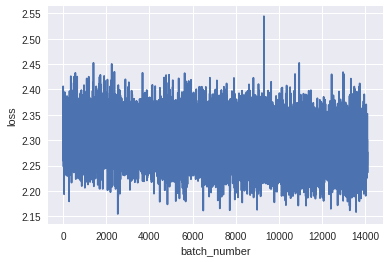

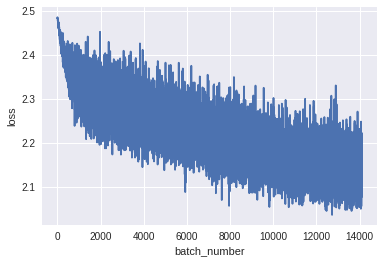

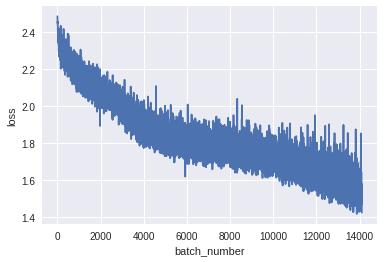

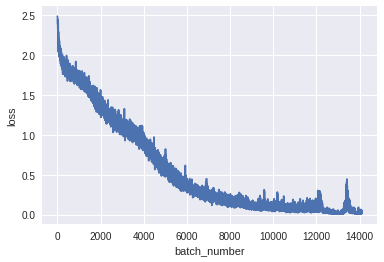

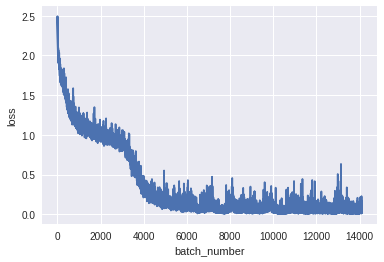

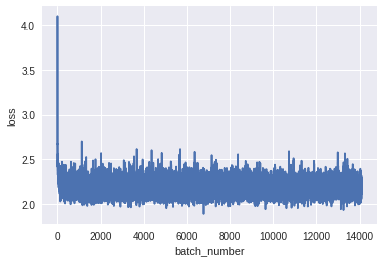

In [17]:
for i, model_info in enumerate(models2):
    print(model_info["params"])
    plt.figure(i)
    plt.xlabel("batch_number")
    plt.ylabel("loss")
    history_loss = model_info["history"]
    plt.plot(range(len(history_loss.losses)), history_loss.losses)

### Plotarea acuratetii din fiecare model

{'optimizer': 'sgd', 'lr': 0.001}
{'optimizer': 'sgd', 'lr': 0.01}
{'optimizer': 'sgd', 'lr': 0.1}
{'optimizer': 'adam', 'lr': 0.001}
{'optimizer': 'adam', 'lr': 0.01}
{'optimizer': 'adam', 'lr': 0.1}


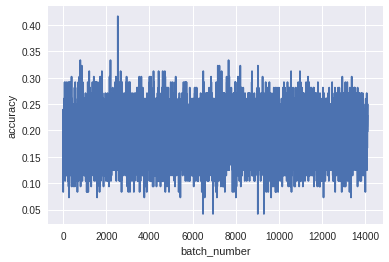

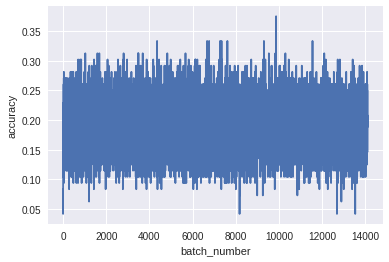

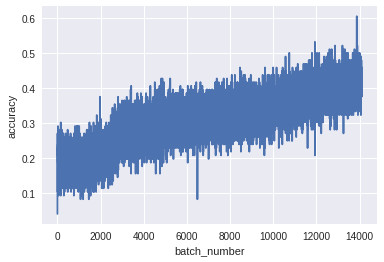

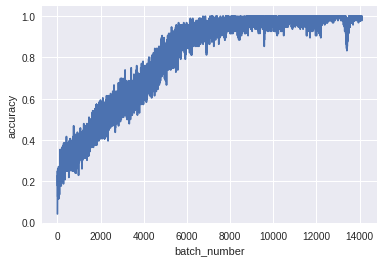

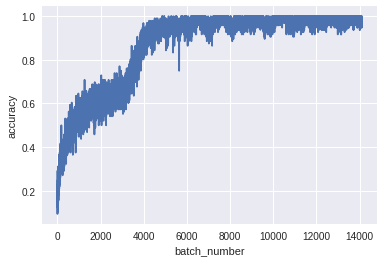

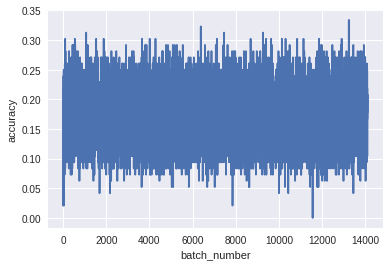

In [18]:
for i, model_info in enumerate(models2):
    print(model_info["params"])
    plt.figure(i)
    plt.xlabel("batch_number")
    plt.ylabel("accuracy")
    history_acc = model_info["history"]
    plt.plot(range(len(history_acc.accuracies)), history_acc.accuracies)

## Exemple decode

In [26]:
def decoder(seq, alphabet):
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    strings = []
    for pattern in seq:
        string = int_to_char[np.argmax(pattern)]
        strings.append(string)
    return ''.join(strings)

model = models2[3]["model"]

result = model.predict(X_test[0:50], batch_size=32, verbose=0)

expected = [decoder(x, alphabet) for x in y_test[0:50]]
predicted = [decoder(x, alphabet) for x in result]

for i in range(len(result)):
    print("Expected=" + str(expected[i]) + ", Predicted=" + str(predicted[i]))

Expected=227, Predicted=227
Expected=339, Predicted=349
Expected=253, Predicted=253
Expected=231, Predicted=231
Expected=124, Predicted=124
Expected=279, Predicted=279
Expected=234, Predicted=234
Expected=93 , Predicted=93 
Expected=61 , Predicted=61 
Expected=204, Predicted=204
Expected=351, Predicted=351
Expected=368, Predicted=368
Expected=379, Predicted=379
Expected=73 , Predicted=73 
Expected=49 , Predicted=49 
Expected=324, Predicted=324
Expected=382, Predicted=382
Expected=386, Predicted=386
Expected=331, Predicted=331
Expected=228, Predicted=228
Expected=443, Predicted=443
Expected=180, Predicted=180
Expected=137, Predicted=137
Expected=217, Predicted=217
Expected=410, Predicted=410
Expected=86 , Predicted=86 
Expected=433, Predicted=433
Expected=236, Predicted=236
Expected=152, Predicted=152
Expected=164, Predicted=164
Expected=194, Predicted=194
Expected=391, Predicted=391
Expected=191, Predicted=191
Expected=311, Predicted=311
Expected=351, Predicted=351
Expected=415, Predic